In [1]:
from FeatureEngineeringUtils.btc_feature_engineering_utils import BtcPreprocessor, TargetExtractor, DataMixer, FeatureEngineer, FeatureExtractor, TrainTestValidationLoader
from ModelingUtils.models import CandlesDataset, WideDeepLSTMNet, train_epoch, test_epoch, save_model_on_validation_improvement, load_model, predict, evaluate

import numpy as np
import torch
import time

## nonstationary TA

In [ ]:
for timeframe in [240]:
    print(f'preprocessing {timeframe}m data')
    btc_preprocessor = BtcPreprocessor(original_timeframe=240, timeframe=timeframe, use_stationary_ta=False)
    btc_preprocessor.run()

In [3]:
for timeframe in [240]:
    target_extractor = TargetExtractor(original_timeframe=240, timeframe=timeframe)
    target_extractor.run()

In [4]:
names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}
first_days = {'none': {'240': '2017-08-28 16:00:00', '60': '2017-08-28 19:00:00', '15': '2017-08-28 19:45:00'}}
last_days = {'target1': '2021-12-31 20:00:00'}

for target in ['target1']:
    for use_exo_data in ['none']:
        for timeframe in [240]:
            data_mixer = DataMixer(df_name=names.get(target).get(str(use_exo_data)).get(str(timeframe)),
                                   timeframe=timeframe, target=target, use_exogenous_data=use_exo_data,
                                   first_day=first_days.get(str(use_exo_data)).get(str(timeframe)),
                                   last_day=last_days.get(target))
            data_mixer.run()

In [5]:
df_names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}
model_name_suffix = {'target1': '1_1'}

for target in ['target1']:
    print('target= ', target)
    for use_exo_data in ['none']:
        for timeframe in [240]:
            engineer = FeatureEngineer(df_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe)),
                                       model_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe))[0:-1] + model_name_suffix.get(target),
                                       target=target, maximum_allowed_correlation_between_features=0.95)
            engineer.run()
            model_name = engineer.model_name
            initial_num_features = engineer.initial_number_of_features
            final_num_features = engineer.number_of_features
            print(f'for {model_name}: initial number of features: {initial_num_features}        final number of features : {final_num_features}')

target=  target1
for btc_4h_for_target1_1: initial number of features: 91        final number of features : 57


In [6]:
names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}

model_name_suffix = {'target1': '1_1'}

for target in ['target1']:
    for use_exo_data in ['none']:
        for timeframe in [240]:
            feature_extractor = FeatureExtractor(df_name=names.get(target).get(str(use_exo_data)).get(str(timeframe)))
            feature_extractor.extract_features(model_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe))[0:-1] + model_name_suffix.get(target),
                                               save=True)

In [7]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = CandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = CandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = CandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 127

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [8]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
wdn = WideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = torch.nn.MSELoss(reduction='mean')
loss_fn2 = torch.nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(wdn.parameters(), lr=lr, weight_decay=4e-4)

wdn.to(device, dtype=torch.double)

Selected device: cuda


WideDeepLSTMNet(
  (deep_lstm): DeepLSTMNet(
    (l1): LSTMCell(57, 90)
    (l2): LSTMCell(90, 66)
    (l3): LSTMCell(66, 48)
    (l4): LSTMCell(48, 24)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
  (wide_lstm): WideLSTMNet(
    (lstm): LSTM(57, 110, batch_first=True)
    (fc): Linear(in_features=110, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [9]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(wdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(wdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(wdn, adam_optimizer, epoch, 'nonstationary_wdn')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0073865 	 total_test 0.0070107 	 execution time: 7

 EPOCH 2/50 	 total_train 0.0060166 	 total_test 0.0064990 	 execution time: 6

 EPOCH 3/50 	 total_train 0.0058315 	 total_test 0.0066405 	 execution time: 6

 EPOCH 4/50 	 total_train 0.0057304 	 total_test 0.0064588 	 execution time: 6

 EPOCH 5/50 	 total_train 0.0056752 	 total_test 0.0065590 	 execution time: 6

 EPOCH 6/50 	 total_train 0.0056308 	 total_test 0.0064794 	 execution time: 6

 EPOCH 7/50 	 total_train 0.0055815 	 total_test 0.0067340 	 execution time: 6

 EPOCH 8/50 	 total_train 0.0055689 	 total_test 0.0063374 	 execution time: 6

 EPOCH 9/50 	 total_train 0.0055300 	 total_test 0.0066010 	 execution time: 6

 EPOCH 10/50 	 total_train 0.0054497 	 total_test 0.0066049 	 execution time: 6

 EPOCH 11/50 	 total_train 0.0054365 	 total_test 0.0070910 	 execution time: 6

 EPOCH 12/50 	 total_train 0.0053787 	 total_test 0.0067201 	 execution time: 6

 EPOCH 13/50 	 total_train 0.0054130

In [10]:
model, adam_optimizer = load_model('torch_models//nonstationary_wdn.pth', wdn, adam_optimizer)

In [11]:
train_preds = predict(model, train_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 7118/7118 [01:04<00:00, 110.89it/s]


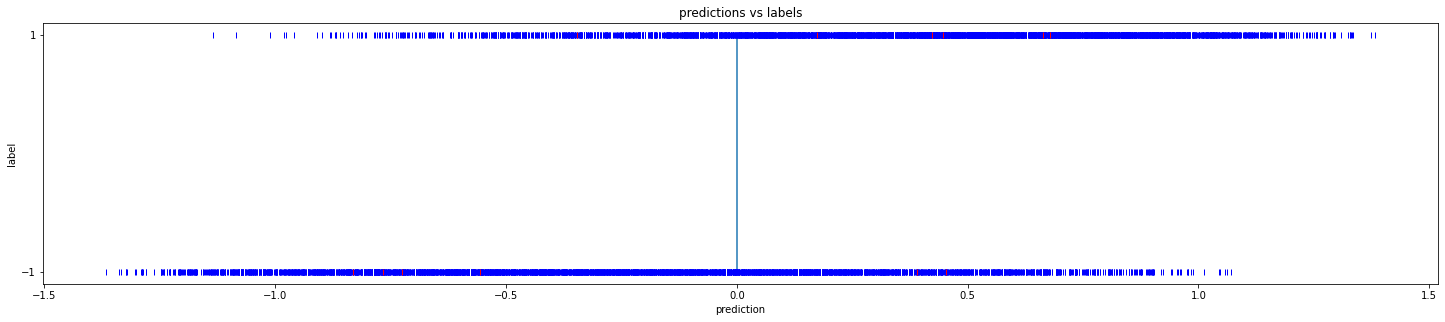

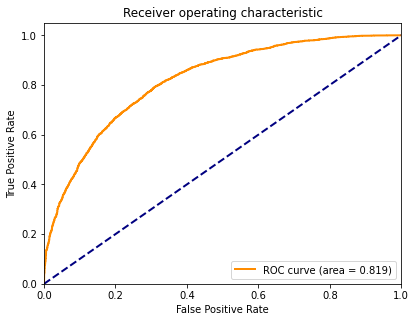

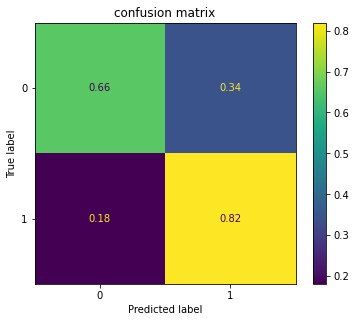

accuracy: 0.7426243326777184
f_score_rise: 0.7707133917396747, precision_rise: 0.7277239423304184, recall_rise: 0.8191008246874169
f_score_fall: 0.7066922830611593, precision_fall: 0.7644613785936959, recall_fall: 0.6570407859481988


(0.8192159794957914, 0.7426243326777184)

In [12]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [13]:
test_preds = predict(model, test_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:12<00:00, 111.12it/s]


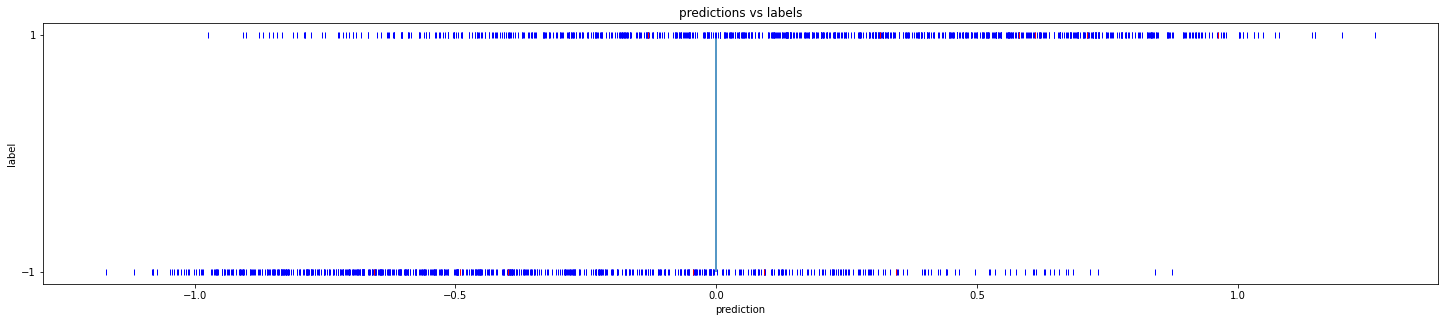

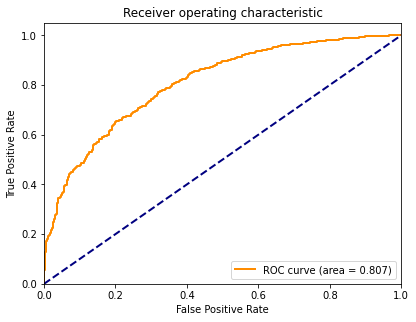

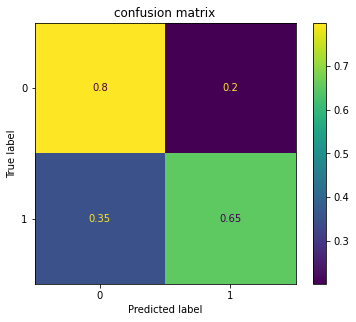

accuracy: 0.7190140845070423
f_score_rise: 0.715203426124197, precision_rise: 0.7927215189873418, recall_rise: 0.6514954486345904
f_score_fall: 0.7227241139680333, precision_fall: 0.6598984771573604, recall_fall: 0.7987711213517665


(0.8074004382574373, 0.7190140845070423)

In [14]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [15]:
val_preds = predict(model, val_dataset, device)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:08<00:00, 109.21it/s]


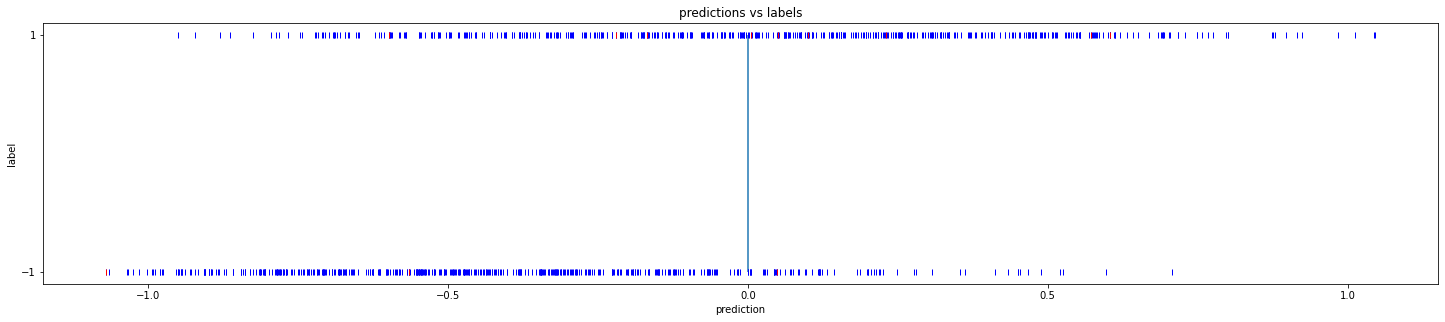

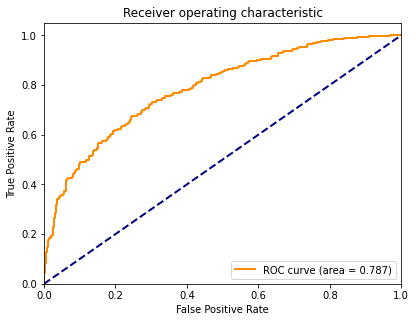

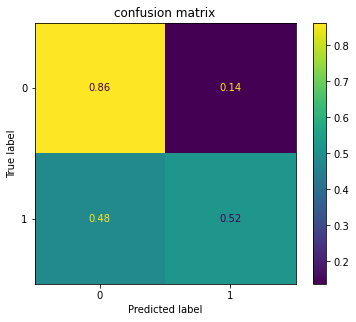

accuracy: 0.6854166666666667
f_score_rise: 0.6299019607843137, precision_rise: 0.8006230529595015, recall_rise: 0.5191919191919192
f_score_fall: 0.7264492753623187, precision_fall: 0.6275430359937402, recall_fall: 0.8623655913978494


(0.7866449440642989, 0.6854166666666667)

In [16]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

## stationarized TA

In [7]:
for timeframe in [240]:
    print(f'preprocessing {timeframe}m data')
    btc_preprocessor = BtcPreprocessor(original_timeframe=240, timeframe=timeframe, use_stationary_ta=True)
    btc_preprocessor.run()

preprocessing 240m data


In [8]:
for timeframe in [240]:
    target_extractor = TargetExtractor(original_timeframe=240, timeframe=timeframe)
    target_extractor.run()

In [9]:
names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}
first_days = {'none': {'240': '2017-08-28 16:00:00', '60': '2017-08-28 19:00:00', '15': '2017-08-28 19:45:00'}}

last_days = {'target1': '2021-12-31 20:00:00'}

for target in ['target1']:
    for use_exo_data in ['none']:
        for timeframe in [240]:
            data_mixer = DataMixer(df_name=names.get(target).get(str(use_exo_data)).get(str(timeframe)),
                                   timeframe=timeframe, target=target, use_exogenous_data=use_exo_data,
                                   first_day=first_days.get(str(use_exo_data)).get(str(timeframe)),
                                   last_day=last_days.get(target))
            data_mixer.run()

In [10]:
df_names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}
model_name_suffix = {'target1': '1_1'}

for target in ['target1']:
    print('target= ', target)
    for use_exo_data in ['none']:
        for timeframe in [240]:
            engineer = FeatureEngineer(df_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe)),
                                       model_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe))[0:-1] + model_name_suffix.get(target),
                                       target=target, maximum_allowed_correlation_between_features=0.95)
            engineer.run()
            model_name = engineer.model_name
            initial_num_features = engineer.initial_number_of_features
            final_num_features = engineer.number_of_features
            print(f'for {model_name}: initial number of features: {initial_num_features}        final number of features : {final_num_features}')

target=  target1
for btc_4h_for_target1_1: initial number of features: 98        final number of features : 74


In [11]:
names = {'target1': {'none': {'240': 'btc_4h_for_target1', '60': 'btc_1h_for_target1', '15': 'btc_15m_for_target1'}}}

model_name_suffix = {'target1': '1_1'}

for target in ['target1']:
    for use_exo_data in ['none']:
        for timeframe in [240]:
            feature_extractor = FeatureExtractor(df_name=names.get(target).get(str(use_exo_data)).get(str(timeframe)))
            feature_extractor.extract_features(model_name=df_names.get(target).get(str(use_exo_data)).get(str(timeframe))[0:-1] + model_name_suffix.get(target),
                                               save=True)

In [12]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = CandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = CandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = CandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 127

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [13]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
wdn = WideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = torch.nn.MSELoss(reduction='mean')
loss_fn2 = torch.nn.L1Loss(reduction='mean')

lr = 16e-4 
adam_optimizer = torch.optim.Adam(wdn.parameters(), lr=lr, weight_decay=4e-4)

wdn.to(device, dtype=torch.double)

Selected device: cuda


WideDeepLSTMNet(
  (deep_lstm): DeepLSTMNet(
    (l1): LSTMCell(74, 90)
    (l2): LSTMCell(90, 66)
    (l3): LSTMCell(66, 48)
    (l4): LSTMCell(48, 24)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
  (wide_lstm): WideLSTMNet(
    (lstm): LSTM(74, 110, batch_first=True)
    (fc): Linear(in_features=110, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [35]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 1
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(wdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(wdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch , num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(wdn, adam_optimizer, epoch, 'stationary_wdn')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement >= patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0051926 	 total_test 0.0059776 	 execution time: 7

 EPOCH 2/50 	 total_train 0.0052654 	 total_test 0.0061744 	 execution time: 7

 EPOCH 3/50 	 total_train 0.0052354 	 total_test 0.0064649 	 execution time: 7

 EPOCH 4/50 	 total_train 0.0051135 	 total_test 0.0065287 	 execution time: 7

 EPOCH 5/50 	 total_train 0.0050975 	 total_test 0.0061503 	 execution time: 7

 EPOCH 6/50 	 total_train 0.0049923 	 total_test 0.0061842 	 execution time: 7


In [39]:
model, adam_optimizer = load_model('torch_models//stationary_wdn.pth', wdn, adam_optimizer)

In [40]:
train_preds = predict(model, train_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 7118/7118 [01:00<00:00, 118.22it/s]


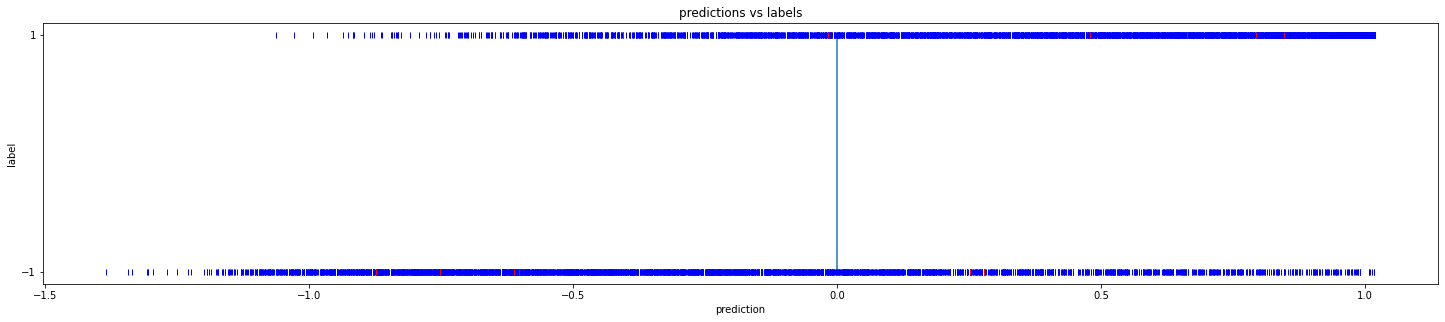

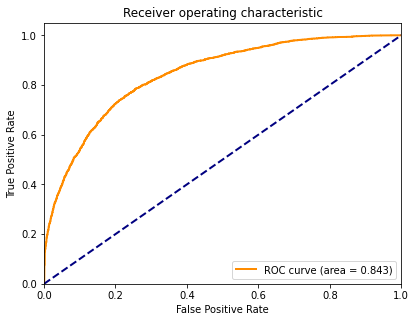

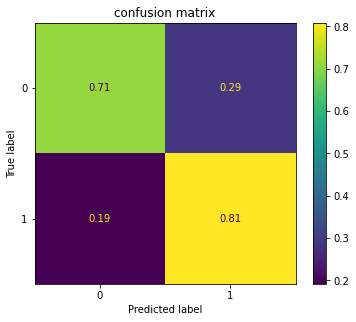

accuracy: 0.7620118010677156
f_score_rise: 0.7820380854348944, precision_rise: 0.75728881136307, recall_rise: 0.8084596967278531
f_score_fall: 0.7379331683168316, precision_fall: 0.7681159420289855, recall_fall: 0.7100327478416195


(0.8426712874315496, 0.7620118010677156)

In [41]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [42]:
test_preds = predict(model, test_dataset, device)

100%|█████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:11<00:00, 118.51it/s]


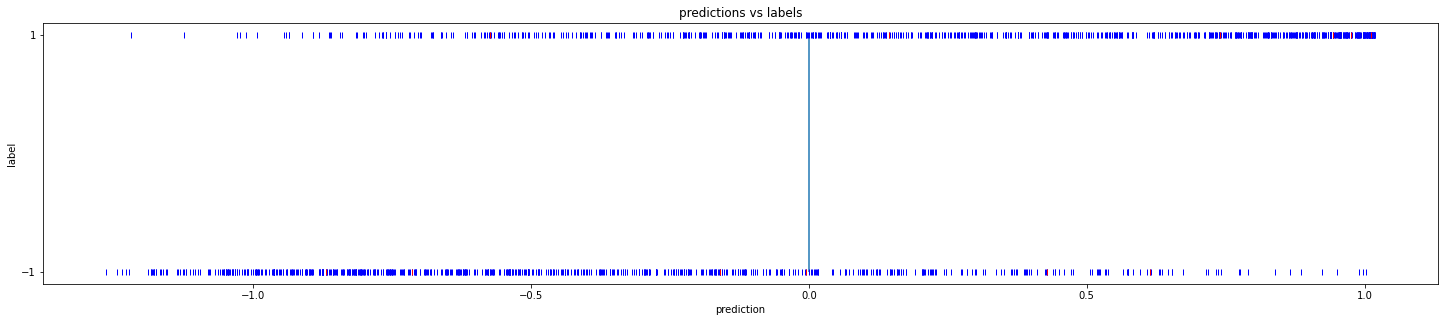

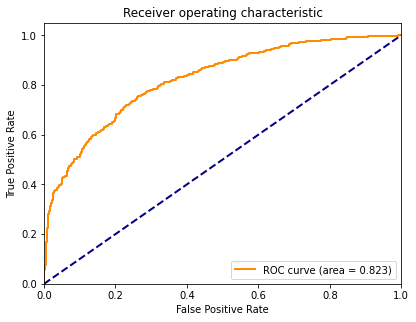

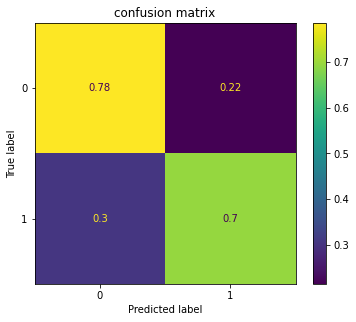

accuracy: 0.7366197183098592
f_score_rise: 0.7409972299168975, precision_rise: 0.7925925925925926, recall_rise: 0.6957087126137841
f_score_fall: 0.7320916905444125, precision_fall: 0.6859060402684564, recall_fall: 0.7849462365591398


(0.8229891394453667, 0.7366197183098592)

In [43]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [44]:
val_preds = predict(model, val_dataset, device)

100%|███████████████████████████████████████████████████████████████████████████████| 960/960 [00:08<00:00, 116.93it/s]


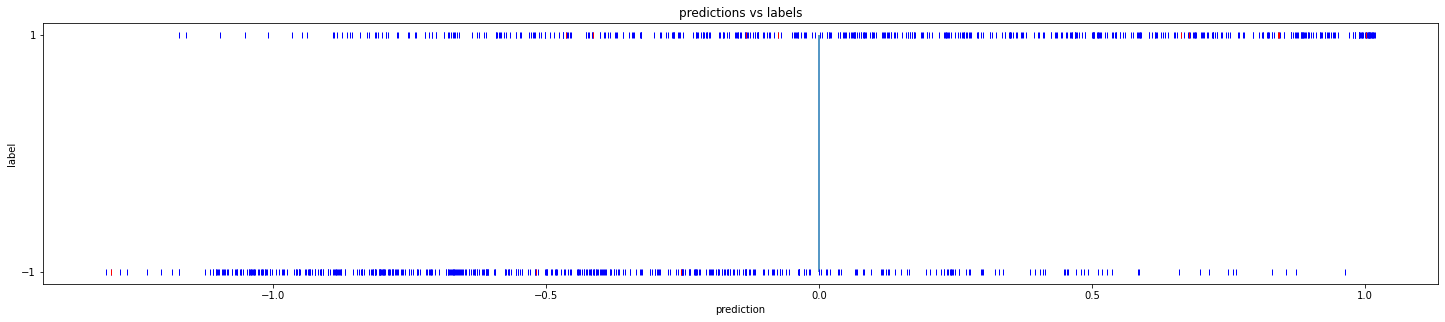

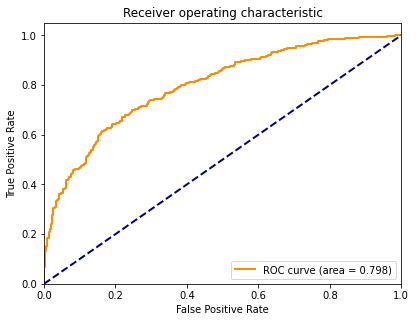

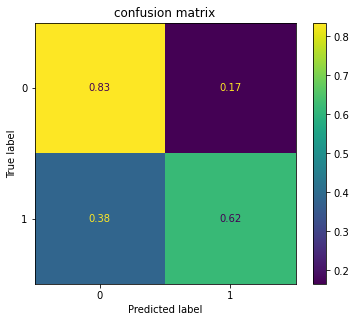

accuracy: 0.721875
f_score_rise: 0.6955530216647662, precision_rise: 0.7984293193717278, recall_rise: 0.6161616161616161
f_score_fall: 0.7440076701821668, precision_fall: 0.671280276816609, recall_fall: 0.8344086021505376


(0.7976669925057022, 0.721875)

In [45]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)